In [11]:
#!pip install tensorflow opencv-python matplotlib

In [12]:
import tensorflow as tf
import os
from PIL import Image

### Data Load

In [13]:
# Convert JPG to PNG - Anamaly
source_directory = "./pcb1/Data/Images/Anomaly/"
destination_directory = "./pcb1/anomaly_png/"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Iterate over the files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith(".JPG"):
        # Open the image file
        image_path = os.path.join(source_directory, filename)
        image = Image.open(image_path)

        # Convert and save the image as .png in the destination directory
        new_filename = os.path.splitext(filename)[0] + ".png"
        destination_path = os.path.join(destination_directory, new_filename)
        image.save(destination_path, "PNG")

print(f"Converted and saved to {destination_directory}")

Converted and saved to ./pcb1/anomaly_png/


In [14]:
# Convert JPG to PNG - Normal
source_directory = "./pcb1/Data/Images/Normal"
destination_directory = "./pcb1/normal_png/"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Iterate over the files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith(".JPG"):
        # Open the image file
        image_path = os.path.join(source_directory, filename)
        image = Image.open(image_path)

        # Convert and save the image as .png in the destination directory
        new_filename = os.path.splitext(filename)[0] + ".png"
        destination_path = os.path.join(destination_directory, new_filename)
        image.save(destination_path, "PNG")

print(f"Converted saved to {destination_directory}")

Converted saved to ./pcb1/normal_png/


- Generally, we also need to remove dodgy images (rule of thumb would be remove images below 10B size). For this case, we know we have cleaned image data, so can skil this step.

In [81]:
import numpy as np
from matplotlib import pyplot as plt

In [82]:
data = tf.keras.utils.image_dataset_from_directory('pcb1')

Found 1104 files belonging to 2 classes.


In [83]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [84]:
data_iterator = data.as_numpy_iterator()

In [85]:
batch = data_iterator.next()

In [86]:
len(batch) # 2 parts to this data: images (loaded as set of numpy arrays) and labels

2

In [87]:
batch[0].shape # 32 batches, 256x256x3 image size, this is the image representation

(32, 256, 256, 3)

In [88]:
# 0 = normal, 1 = defect (anomaly)
batch[1] # this is the label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

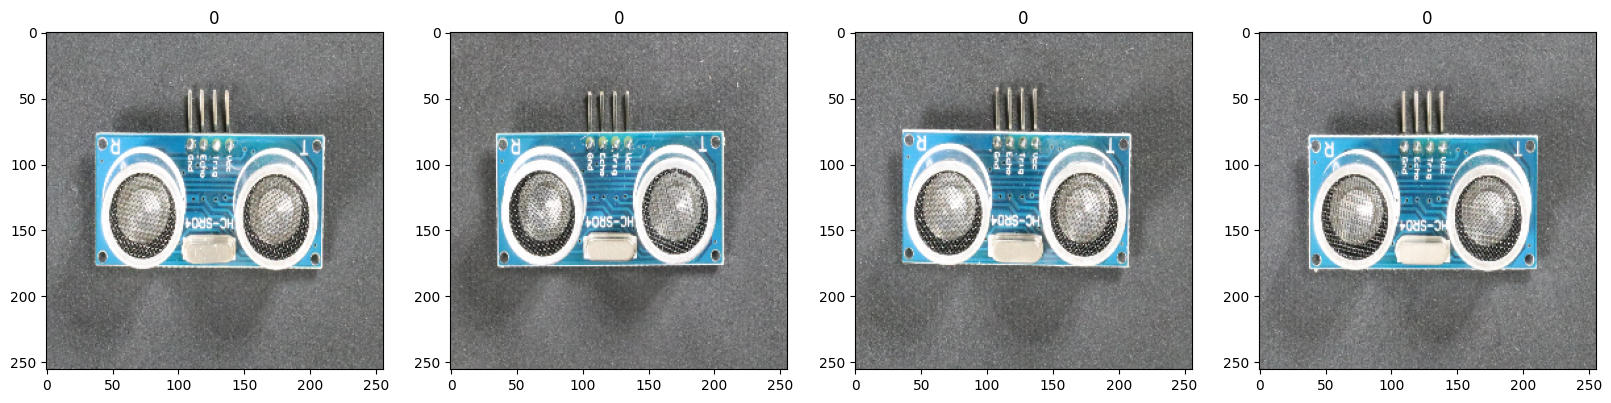

In [89]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Data Preprocessing
1. Scaling the image values to be 0 to 1 instead of to 255.
2. Split data into train / validation / test.

In [90]:
# Scale data
data = data.map(lambda x,y: (x/255, y)) # x indicates the images, y is the labels

In [91]:
data.as_numpy_iterator().next()[0].max()

1.0

In [92]:
data.as_numpy_iterator().next()[0].min()

0.0072309906

In [93]:
# Split data
len(data)

35

In [94]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [95]:
train_size

24

In [96]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [97]:
len(test)

3

### Deep Learning Model

In [98]:
from tensorflow.keras.models import Sequential # Sequential is the quick and easy version
# 2D convolution, Condense it down, connected layer, channels reduces back in to the format, regularization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

In [99]:
model = Sequential()

In [100]:
# 16 filters where our filter is 3 pixel x 3 pixel in size, and have a stride of 1. Apply relu activation function to 256x256x3 images
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) 
# Apply max pooling layer - scan across by 2x2 region and take max value to condense the info down by half
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# Takes a single output into a sigmoid function which will classify into either 0 or 1
model.add(Dense(1, activation='sigmoid'))

C:\Users\tom.kim\OneDrive - S&P Global\Desktop\Data Science\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=[Recall(name='recall')])

In [102]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Train
logdir = 'logs'

# Useful to save model and create check points
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [115]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 555ms/step - loss: 0.0663 - recall: 0.6493 - val_loss: 0.1037 - val_recall: 0.6364
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 611ms/step - loss: 0.0397 - recall: 0.8849 - val_loss: 0.0894 - val_recall: 1.0000
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 595ms/step - loss: 0.0303 - recall: 0.9364 - val_loss: 0.0584 - val_recall: 0.7222
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 588ms/step - loss: 0.0234 - recall: 0.8655 - val_loss: 0.0468 - val_recall: 0.8095
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 701ms/step - loss: 0.0134 - recall: 0.9881 - val_loss: 0.0356 - val_recall: 1.0000
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 662ms/step - loss: 0.0107 - recall: 0.9933 - val_loss: 0.0367 - val_recall: 1.0000
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 661ms/step - loss: 0.0118 - recall: 0.9698 - val_loss: 0.0754 - val_recall: 1.0000
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 656ms/step - loss: 0.0381 - recall: 0.9477 - val_loss: 0.0587 - val_recall: 0.8800


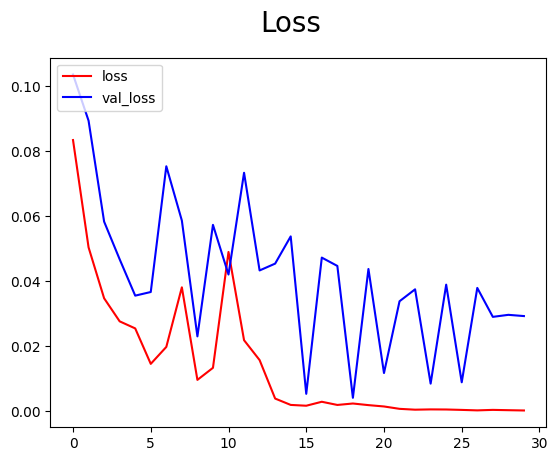

In [116]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label='loss')
plt.plot(hist.history['val_loss'], color = 'blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

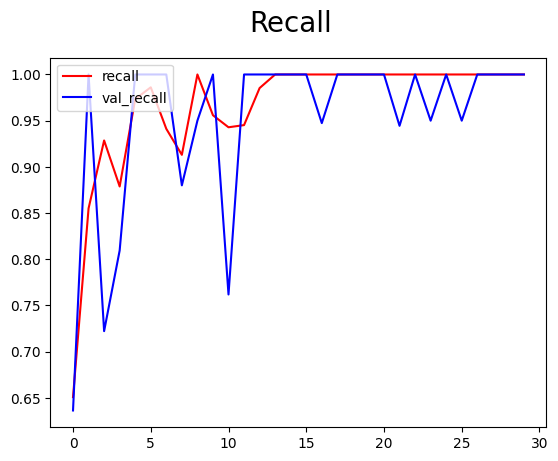

In [117]:
fig = plt.figure()
plt.plot(hist.history['recall'], color = 'red', label='recall')
plt.plot(hist.history['val_recall'], color = 'blue', label='val_recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

- Our model seems to perform well against the validation set, reaching around 95% - 100% for recall rate. Recall, or sensitivity score, is defined as the proportion of true positive detections among all actual positives, which would be defect parts in this case.

### Evaluate Performance

In [133]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [136]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [137]:
all_true = []
all_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)
    
    predicted_classes = (yhat > 0.5).astype(int).reshape(-1)
    true_classes = y.reshape(-1)

    # Accumulate the true and predicted labels
    all_true.extend(true_classes)
    all_pred.extend(predicted_classes)

# Compute the confusion matrix
cm = confusion_matrix(all_true, all_pred)
classes = np.unique(all_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [140]:
print(f'Precision :{precision.result().numpy()}, Recall :{recall.result().numpy()}, Accuracy :{accuracy.result().numpy()}')

Precision :0.8571428656578064, Recall :1.0, Accuracy :0.9895833134651184


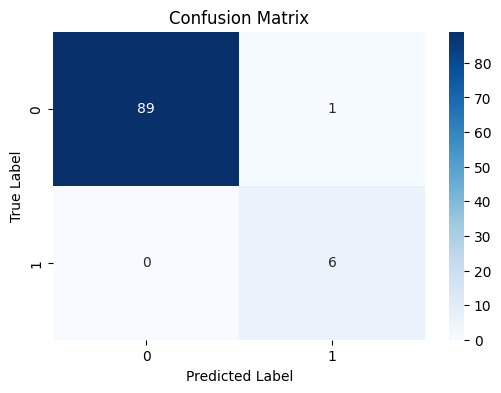

In [139]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

- Overall, out of 96 test images (3 batches with 32 images per batch), our deep learning model was able to classify with 99% accuracy and 100% recall, which means that the model was able to detect all of the defect components. We did have a precision score of 86% which signifies that the model mis-classified one normal part into a defect category. 